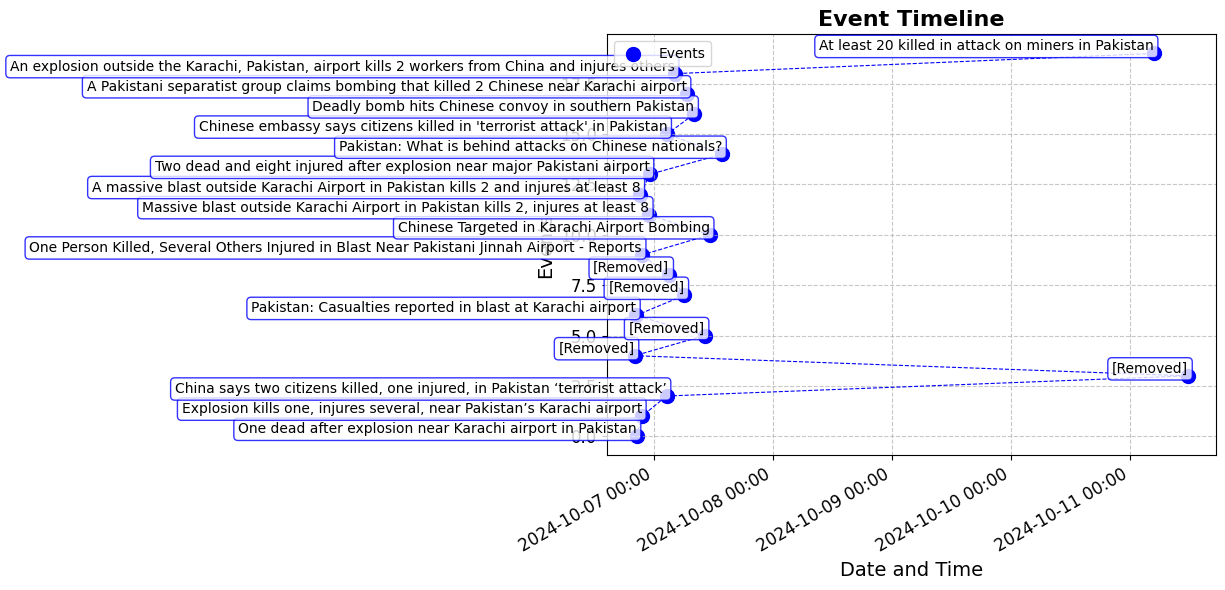

No. of events found:  20
Summary of Events:
- One dead after explosion near Karachi airport in Pakistan (Source: https://www.bbc.com/news/articles/c0r84p0dp1jo, Date: 2024-10-06T20:24:05Z)
  Sentiment: NEGATIVE (0.73)
  Key Entities: Jinnah International Airport, Sunday night

- Explosion kills one, injures several, near Pakistan’s Karachi airport (Source: https://www.aljazeera.com/news/2024/10/6/deadly-explosion-near-karachi-airport-in-pakistan, Date: 2024-10-06T21:28:41Z)
  Sentiment: NEGATIVE (0.98)
  Key Entities: Pakistani, Balochistan Liberation Army

- China says two citizens killed, one injured, in Pakistan ‘terrorist attack’ (Source: https://www.aljazeera.com/news/2024/10/7/china-says-two-citizens-killed-one-injured-in-pakistan-terrorist-attack, Date: 2024-10-07T02:27:42Z)
  Sentiment: NEGATIVE (1.00)
  Key Entities: At least 10, the Port Qasim Electric Power Company, Karachi airport

- [Removed] (Source: https://removed.com, Date: 2024-10-11T11:45:26Z)
  Sentiment: NEGATIVE (

In [2]:
import requests
import praw
import spacy
import re
from transformers import pipeline
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from top2vec import Top2Vec
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime

# Set up API keys (ensure security in a real application)
NEWS_API_KEY = 'a8bcc3d808424f098069111c114e3ff8'
reddit = praw.Reddit(client_id='KuFv8c21pkf0y6_BHw5pzw',
                     client_secret='	x7XZmNwQR0Z01XFhpRT-rUzfvwD1jg',
                     user_agent='NarrativeAI by RuggyMango')

# Function to fetch news from NewsAPI
def get_news(keyword, page_size=20):
    url = f'https://newsapi.org/v2/everything?q={keyword}&apiKey={NEWS_API_KEY}&pageSize={page_size}'
    response = requests.get(url)
    articles = response.json().get('articles', [])
    
    news = []
    for article in articles:
        news.append({
            'title': article['title'],
            'description': article['description'],
            'url': article['url'],
            'publishedAt': article['publishedAt'],
            'content': article['content']
        })
    return news

# Function to fetch top Reddit posts
def fetch_top_posts(search_query, subreddit_name='all', limit=10):
    subreddit = reddit.subreddit(subreddit_name)
    top_posts = subreddit.search(search_query, sort='top', limit=limit)
    
    post_data = []
    for post in top_posts:
        post_datetime = datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S')
        upvotes = post.ups
        downvotes = upvotes - post.score
        awards = post.all_awards if hasattr(post, 'all_awards') else []
        award_names = [award['name'] for award in awards]
        flair = post.link_flair_text if post.link_flair_text else "No Flair"
        
        post_data.append({
            'Title': post.title,
            'Body': post.selftext,
            'Date': post_datetime,
            'Upvotes': upvotes,
            'Downvotes': downvotes,
            'Comments': post.num_comments,
            'Link': post.url,
            'Awards': award_names,
            'Flair': flair
        })
    
    return post_data

# Function to clean and preprocess text
nlp = spacy.load("en_core_web_sm")
def preprocess_text(text):
    text = re.sub(r"http\S+|www\S+|https\S+", '', text)
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    return " ".join(tokens)

# Named Entity Recognition
def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

# Sentiment analysis with explicit model specification
sentiment_analyzer = pipeline('sentiment-analysis', model="distilbert-base-uncased-finetuned-sst-2-english", revision="af0f99b")
def analyze_sentiment(text):
    return sentiment_analyzer(text)

# Topic Modeling with Top2Vec
# def get_topics(documents):
#     # Prepare tagged data for Doc2Vec
#     tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(documents)]
    
#     # Initialize and build vocabulary
#     model = Doc2Vec(vector_size=100, min_count=2, epochs=40, workers=4)
#     model.build_vocab(tagged_data,update=False)  # Ensure vocabulary is built
    
#     # Train the model
#     model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
    
#     # Use Top2Vec for topic modeling
#     top2vec_model = Top2Vec(documents, embedding_model='sentence_transformers')
    
#     topics, topic_words, word_scores, topic_scores = top2vec_model.get_topics()
#     return topics, topic_words, word_scores, topic_scores
from gensim import corpora
from gensim.models import LdaModel

def get_topics(documents, num_topics=5):
    # Preprocess documents into a list of tokenized words
    tokenized_docs = [doc.split() for doc in documents]
    
    # Create a dictionary and corpus for LDA
    dictionary = corpora.Dictionary(tokenized_docs)
    corpus = [dictionary.doc2bow(doc) for doc in tokenized_docs]
    
    # Train LDA model
    lda_model = LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    
    # Get topics and their words
    topics = lda_model.show_topics(num_words=4, formatted=False)
    
    # Extract topic words and scores
    topic_words = []
    word_scores = []
    
    for topic in topics:
        words, scores = zip(*topic[1])
        topic_words.append([word for word in words])
        word_scores.append(scores)

    # Return formatted topics
    return topics, topic_words, word_scores, None  # None for topic_scores as it's not relevant for LDA


# Event Timeline Plotting
# def plot_timeline(events):
#     event_dates = [datetime.strptime(event['date'], "%Y-%m-%dT%H:%M:%SZ") for event in events]
#     event_texts = [event['text'] for event in events]
    
#     plt.figure(figsize=(10, 5))
#     plt.plot(event_dates, [i for i in range(len(event_dates))], 'bo-')
    
#     for i, text in enumerate(event_texts):
#         plt.text(event_dates[i], i, text, fontsize=9, verticalalignment='bottom', horizontalalignment='right')
    
#     plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
#     plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=2))
#     plt.gcf().autofmt_xdate()
#     plt.title("Event Timeline")
#     plt.xlabel("Date and Time")
#     plt.ylabel("Events")
#     plt.grid(True)
#     plt.show()

def plot_timeline(events):
    event_dates = [datetime.strptime(event['date'], "%Y-%m-%dT%H:%M:%SZ") for event in events]
    event_texts = [event['text'] for event in events]
    
    plt.figure(figsize=(12, 6))
    
    # Create a scatter plot with markers
    plt.scatter(event_dates, [i for i in range(len(event_dates))], color='blue', s=100, label='Events')
    
    # Draw lines connecting the events
    plt.plot(event_dates, [i for i in range(len(event_dates))], color='blue', linestyle='dashed', linewidth=0.8)

    for i, text in enumerate(event_texts):
        plt.text(event_dates[i], i, text, fontsize=10, verticalalignment='bottom', horizontalalignment='right', bbox=dict(facecolor='white', alpha=0.8, edgecolor='blue', boxstyle='round,pad=0.3'))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m-%d %H:%M"))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
    plt.gcf().autofmt_xdate()

    plt.title("Event Timeline", fontsize=16, fontweight='bold')
    plt.xlabel("Date and Time", fontsize=14)
    plt.ylabel("Events", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
    plt.show()


# Main function to combine everything
def summarize_event(topic):
    try:
        # Fetch news and reddit data
        news_articles = get_news(topic)
        # reddit_posts = fetch_top_posts(topic)
        
        # Combine and preprocess data
        combined_data = [article['description'] for article in news_articles if article['description']] 
        # + \
                        # [post['Body'] for post in reddit_posts if post['Body']]

        cleaned_data = [preprocess_text(text) for text in combined_data]
        
        # Perform topic modeling
        topics, topic_words, _, _ = get_topics(cleaned_data)
        
        # Extract entities and sentiment for each news and reddit post
        events = []
        for article in news_articles:
            sentiment = analyze_sentiment(article['description'])
            entities = extract_entities(article['description'])
            events.append({
                'text': article['title'],
                'sentiment': sentiment,
                'entities': entities,
                'source': article['url'],
                'date': article['publishedAt'],
                'description': article['description'],
                'content': article['content']
            })
        
        # for post in reddit_posts:
        #     sentiment = analyze_sentiment(post['Body'])
        #     entities = extract_entities(post['Body'])
        #     events.append({
        #         'text': post['Title'],
        #         'sentiment': sentiment,
        #         'entities': entities,
        #         'source': post['Link'],
        #         'date': post['Date']
        #     })
        
        # Plot timeline
        plot_timeline(events)
        
        # Print structured summary
        print("No. of events found: ", len(events))
        print("Summary of Events:")
        for event in events:
            print(f"- {event['text']} (Source: {event['source']}, Date: {event['date']})")
            print(f"  Sentiment: {event['sentiment'][0]['label']} ({event['sentiment'][0]['score']:.2f})")
            print(f"  Key Entities: {', '.join([ent[0] for ent in event['entities']])}")
            # print(f"  Description: {event['description']}")
            # print(f"  Content: {event['content']}")
            print()

    except Exception as e:
        print(f"An error occurred: {e}")

# Input from user
if __name__ == "__main__":
    # topic = input("Enter the event/topic: ")
    # summarize_event(topic)
    summarize_event("karachi airport explosion")
